# __Cluster Analysis of Metro Station Areas__

The aim of this essay is to perform a cluster analysis of Prague metro stations based on the spatial pattern of the 100 nearest venues 
in order to gain insight into the characteristics of station's catchment areas. 
Based on the unique characteristics of the catchment areas, a typology of stations will be proposed in order to assess their primary functions and roles in the city.
The radius to locate the 100 closest venues was set at 400 meters for each stations beacuse pedestrian using these stations should be able to reach the venues within a five-minute walking distance (the 400-meter distance). 

The Foursquare venue data was gathered using the Foursquare API database and Metro stations data was obtained from Geoportal of Prague.

In [1]:
# Import all necessary libraries
import warnings

import contextily
import pointpats

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from libpysal import graph
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Ignore all warnings
warnings.filterwarnings('ignore')

## __Data exploration__

First, load and check the data.

In [3]:
# Read metro stations data
metro = gpd.read_file('metro5514.gpkg')
metro.head(2)  

Station Name Metro Line      Latitude      Longitude  \
0        Anděl          B -1.044858e+06 -744313.969031   
1   Bořislavka          A -1.041243e+06 -746724.949597   

                              Coordinates                          geometry  
0  -1044858.4166476722,-744313.9690311057  POINT (-744313.969 -1044858.417)  
1  -1041242.8838896882,-746724.9495974302  POINT (-746724.950 -1041242.884)

In [4]:
# Read venues data
venues = gpd.read_file('venues5514.gpkg')
venues.head(2)

Venue Type Venue Subtype                Venue Name  \
0  Arts and Entertainment        Casino  Casino Top Games Admiral   
1  Arts and Entertainment   Gaming Cafe      Dětský klub Barbucha   

  Station Name Metro Line  Venue Latitude  Venue Longitude  \
0        Anděl          B   -1.044853e+06   -744240.344475   
1        Anděl          B   -1.044876e+06   -744408.218547   

                       Venue Coordinates                          geometry  
0  -1044853.1203531758,-744240.344474776  POINT (-744240.344 -1044853.120)  
1   -1044876.2352441632,-744408.21854658  POINT (-744408.219 -1044876.235)

Then, let's explore the structure of the metro lines and the spatial distribution of metro stations across the city.

Number of total metro stations: 58


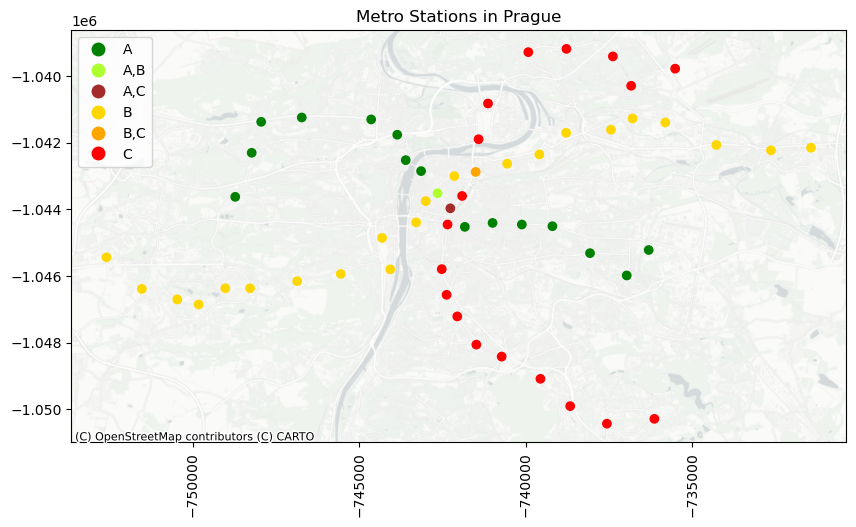

In [5]:
# Explore Metro Stations data
print('Number of total metro stations:', len(metro))

# Create a colormap for metro stations
cmap = ListedColormap(['green', 'greenyellow', 'brown', 'gold', 'orange', 'red'])

# Plot the metro stations
ax =metro.plot(column='Metro Line', legend=True, figsize=(10, 10), cmap=cmap)
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=metro.crs,
    source="CartoDB Positron No Labels",
)
plt.title('Metro Stations in Prague')
plt.xticks(rotation=90)
plt.show()

Let's also find out the total number of venues, the number of unique categories in the venues data, and the number of venues in each category.

In [6]:
#Explore venues data
print('Number of total venues:', venues['Venue Type'].value_counts().sum())

print('Unique venue types:', len(venues['Venue Type'].unique()),'\n')

print(venues['Venue Type'].value_counts(),'\n')

Number of total venues: 4557
Unique venue types: 10 

Venue Type
Dining and Drinking                   565
Retail                                563
Business and Professional Services    561
Community and Government              507
Travel and Transportation             480
Landmarks and Outdoors                452
Health and Medicine                   442
Sports and Recreation                 371
Arts and Entertainment                346
Event                                 270
Name: count, dtype: int64 



Let's explore the structure of the venues as well - what are the most common Venue Subtypes in the 10 Venue Types?

In [7]:
# Find out the most common venue subtypes for each venue type
top_5_subtypes_by_type = venues.groupby('Venue Type')['Venue Subtype'].apply(lambda x: x.value_counts().nlargest(5).index.tolist())

for venue_type, top_5_subtypes in top_5_subtypes_by_type.items():
    print(f"{venue_type}: {top_5_subtypes}")

Arts and Entertainment: ['Art Gallery', 'Public Art', 'Arts and Entertainment', 'Night Club', 'Casino']
Business and Professional Services: ['Health and Beauty Service', 'Bank', 'ATM', 'Business and Professional Services', 'Coworking Space']
Community and Government: ['Residential Building', 'College Classroom', 'Government Building', 'Elementary School', 'Language School']
Dining and Drinking: ['Bakery', 'Pizzeria', 'Coffee Shop', 'Grocery Store', 'Café']
Event: ['Event Space', 'Event Service', 'Bar', 'Pizzeria', 'Restaurant']
Health and Medicine: ["Doctor's Office", 'Dentist', 'Medical Center', 'Physician', 'Health and Medicine']
Landmarks and Outdoors: ['Office Building', 'Playground', 'Park', 'Other Great Outdoors', 'Dog Park']
Retail: ['Grocery Store', 'Drugstore', 'Clothing Store', 'Convenience Store', 'Newsstand']
Sports and Recreation: ['Gym and Studio', 'Dance Studio', 'Sports and Recreation', 'Yoga Studio', 'Indoor Play Area']
Travel and Transportation: ['Bus Stop', 'Hotel', 

Ok, this does not seem right, why is 'Bar', 'Pizzeria' and 'Restaurant' listed as 'Event' and why is 'Grocery Store' listed as 'Dining and Drinking' when there is category for 'Retail'? Let's Explore the data little bit more.

### __Data Cleaning__

In [8]:
# Create a function to explore subtypes of each venue type
def explore_subtypes(venues, venue_type):
    subtypes = venues[venues['Venue Type'] == venue_type]['Venue Subtype'].unique()
    print(f'{venue_type}:\n', sorted(subtypes))

venue_types = ['Arts and Entertainment', 'Business and Professional Services', 'Community and Government',
               'Dining and Drinking', 'Event', 'Health and Medicine', 'Landmarks and Outdoors', 'Retail',
               'Sports and Recreation', 'Travel and Transportation']

for venue_type in venue_types:
    explore_subtypes(venues, venue_type)

Arts and Entertainment:
 ['Amusement Park', 'Aquarium', 'Arcade', 'Art Gallery', 'Art Museum', 'Arts and Crafts Store', 'Arts and Entertainment', 'Bar', 'Bowling Alley', 'Café', 'Casino', 'Circus', 'College Gym', 'Comedy Club', 'Concert Hall', 'Convention Center', 'Coworking Space', 'Dance Studio', 'Disc Golf Course', 'Education', 'Escape Room', 'Event Space', 'Exhibit', 'Gaming Cafe', 'Golf Course', 'Historic and Protected Site', 'History Museum', 'Indie Theater', 'Internet Cafe', 'Korean Restaurant', 'Laser Tag Center', 'Lounge', 'Massage Clinic', 'Mini Golf Course', 'Movie Theater', 'Museum', 'Music Venue', 'Night Club', 'Non-Profit Organization', 'Performing Arts Venue', 'Pool Hall', 'Psychic and Astrologer', 'Pub', 'Public Art', 'Restaurant', 'Rock Club', 'Salsa Club', 'Science Museum', 'Social Club', 'Stadium', 'Strip Club', 'Structure', 'Tea Room', 'Theater', 'Ticket Seller', 'Travel Lounge', 'Tunnel', 'Water Park', 'Zoo']
Business and Professional Services:
 ['ATM', 'Advertisin

The function `explore_subtypes` lists the subtypes of each venue type. The lists show that there are a number of subtypes that are incorrectly categorized.

According to Foursquare API documentation `[Foursquare](https://location.foursquare.com/places/docs/categories)`, the categories in 'Event' should be time limited events like 
'Conference', 'Convention', 'Entertainment Event', 'Line', 'Marketplace' or 'Other Event',  but non of these events were found and are not in the data. Therefore, we can drop this category.

When exploring the subtypes of 'Dining and Drinking', we can see that there are a lot of subtypes, so we can create new categories - 'Nightlife' and 'Cafes and Bakeries'.
Also, there is no need for the subtype 'Metro Station' as the analysis focuses on venues around metro stations.


In [9]:
# Drop row in 'Travel and Transportation' if the subtype is 'Metro Station'
venues.drop(venues[(venues['Venue Type'] == 'Travel and Transportation') & (venues['Venue Subtype'] == 'Metro Station')].index, inplace=True)

# Rename venue type Event to Nightlife
venues.loc[venues['Venue Type'] == 'Event', 'Venue Type'] = 'Nightlife'

# Move subtypes into their correct category 
change_category = {
    'Adult Education': 'Community and Government',
    'American Restaurant': 'Dining and Drinking',
    'Amusement Park': 'Arts and Entertainment',
    'Apartment or Condo': 'Travel and Transportation',
    'Art Gallery': 'Arts and Entertainment',
    'Arts and Entertainment': 'Arts and Entertainment',
    'Asian Restaurant': 'Dining and Drinking',
    'Automotive Service': 'Business and Professional Services',
    'BBQ Joint': 'Dining and Drinking',
    'Bakery': 'Cafes and Bakeries',
    'Bank': 'Business and Professional Services',
    'Bar': 'Nightlife',
    'Beer Bar': 'Nightlife',
    'Beer Garden': 'Nightlife',
    'Beer Store': 'Retail',
    'Belgian Restaurant': 'Dining and Drinking',
    'Bicycle Strore': 'Retail',
    'Bistro': 'Dining and Drinking',
    'Buffet': 'Dining and Drinking',
    'Burger Joint': 'Dining and Drinking',
    'Business and Professional Services': 'Business and Professional Services',
    'Cafe, Coffee, and Tea House': 'Cafes and Bakeries',
    'Cafeteria': 'Dining and Drinking',
    'Café': 'Cafes and Bakeries',
    'Camera Store': 'Retail',
    'Car Wash and Detail': 'Retail',
    'Casino': 'Nightlife',
    'Chinese Restaurant': 'Dining and Drinking',
    'Childrens Hospital': 'Health and Medicine',
    'Child Care Service': 'Community and Government',
    'Chocolate Store': 'Retail',
    'Clothing Store': 'Retail',
    'Cocktail Bar': 'Nightlife',
    'Coffee Shop': 'Cafes and Bakeries',
    'Community Center': 'Community and Government',
    'Concert Hall': 'Arts and Entertainment',
    'Construction': 'Business and Professional Services',
    'Convenience Store': 'Retail',
    'Convention Center': 'Community and Government',
    'Cosmetics Store': 'Retail',
    'Cuban Restaurant': 'Dining and Drinking',
    'Cultural Center': 'Arts and Entertainment',
    'Cupcake Shop': 'Cafes and Bakeries',
    'Czech Restaurant': 'Dining and Drinking',
    'Dance Studio': 'Sports and Recreation',
    'Daycare': 'Community and Government',
    'Deli': 'Dining and Drinking',
    'Department Store': 'Retail',
    'Dessert Shop': 'Cafes and Bakeries',
    'Diner': 'Dining and Drinking',
    'Dining and Drinking': 'Dining and Drinking',
    'Dive Bar': 'Nightlife',
    'Driving School': 'Business and Professional Services',
    'Drugstore': 'Retail',
    'Eastern European Restaurant': 'Dining and Drinking',
    'Education': 'Community and Government',
    'Event Service': 'Business and Professional Services',
    'Event Space': 'Arts and Entertainment',
    'Farmers Market': 'Retail',
    'Fast Food Restaurant': 'Dining and Drinking',
    'Financial Service': 'Business and Professional Services',
    'Fish Market': 'Retail',
    'Food and Beverage Retail': 'Retail',
    'French Restaurant': 'Dining and Drinking',
    'Fruit and Vegetable Store': 'Retail',
    'Garden': 'Landmarks and Outdoors',
    'Gastropub': 'Dining and Drinking',
    'Gift Store': 'Retail',
    'Grocery Store': 'Retail',
    'Gourmet Store': 'Retail',
    'Government Building': 'Community and Government',
    'Gym and Studio': 'Sports and Recreation',
    'Hair Salon': 'Business and Professional Services',
    'Health Food Store': 'Retail',
    'Health and Beauty Service': 'Business and Professional Services',
    'Health and Medicine': 'Health and Medicine',
    'History Museum': 'Arts and Entertainment',
    'Herbs and Spices Store': 'Retail',
    'Hookah Bar': 'Nightlife', 
    'Home Improvement Service': 'Business and Professional Services',
    'Hostel': 'Travel and Transportation',
    'Hotel': 'Travel and Transportation',
    'Hotel Bar': 'Travel and Transportation',
    'Housing Development': 'Business and Professional Services',
    'Hungarian Restaurant': 'Dining and Drinking',
    'Ice Cream Parlor': 'Cafes and Bakeries',
    'Imported Food Store': 'Retail',
    'Indian Restaurant': 'Dining and Drinking',
    'Indie Movie Theater': 'Arts and Entertainment',
    'Indoor Play Area': 'Sports and Recreation',
    'Insurance Agency': 'Business and Professional Services',
    'Italian Restaurant': 'Dining and Drinking',
    'Karaoke Bar': 'Nightlife',
    'Korean Restaurant': 'Dining and Drinking',
    'Latin American Restaurant': 'Dining and Drinking',
    'Law Office': 'Business and Professional Services',
    'Lebanese Restaurant': 'Dining and Drinking',
    'Library': 'Community and Government',
    'Liquor Store': 'Retail',
    'Lounge': 'Dining and Drinking',
    'Massage Clinic': 'Health and Medicine',
    'Media Agency': 'Business and Professional Services',
    'Mexican Restaurant': 'Dining and Drinking',
    'Middle Eastern Restaurant': 'Dining and Drinking',
    'Mini Golf Course': 'Sports and Recreation',
    'Miscellaneous Shop': 'Retail',
    'Mobile Phone Store': 'Retail',
    'Modern European Restaurant': 'Dining and Drinking',
    'Music Venue': 'Arts and Entertainment',
    'New American Restaurant': 'Dining and Drinking',
    'Night Club': 'Nightlife',
    'Non-Profit Organization': 'Community and Government',
    'Office': 'Business and Professional Services',
    'Office Building': 'Business and Professional Services',
    'Office Supply Store': 'Retail',
    'Organization': 'Community and Government',
    'Organic Grocery': 'Retail',
    'Park': 'Landmarks and Outdoors',
    'Pastry Shop': 'Cafes and Bakeries',
    'Pizzeria': 'Dining and Drinking',
    'Plastisc Supplier': 'Retail',
    'Pool Hall': 'Arts and Entertainment',
    'Pub': 'Nightlife',
    'Ramen Restaurant': 'Dining and Drinking',
    'Real Estate Agency': 'Business and Professional Services',
    'Restaurant': 'Dining and Drinking',
    'Retail': 'Retail',
    'Rooftop Bar': 'Nightlife',
    'Rock Club': 'Nightlife',
    'Russian Restaurant': 'Dining and Drinking',
    'Seafood Restaurant': 'Dining and Drinking',
    'Spa': 'Sports and Recreation',
    'Sports Bar': 'Nightlife',
    'Sports and Recreation': 'Sports and Recreation',
    'Steakhouse': 'Dining and Drinking',
    'Storage Facility': 'Business and Professional Services',   
    'Strip Club': 'Nightlife',
    'Sushi Restaurant': 'Dining and Drinking',
    'Synagogue': 'Community and Government',
    'Tanning Salon': 'Business and Professional Services',
    'Tapas Restaurant': 'Dining and Drinking',
    'Tea Room': 'Cafes and Bakeries',
    'Tennis Court': 'Sports and Recreation',
    'Thai Restaurant': 'Dining and Drinking',
    'Theater': 'Arts and Entertainment',
    'Tourist Information and Service': 'Business and Professional Services',
    'Toy Store': 'Retail',
    'Travel Agency': 'Travel and Transportation',
    'Travel Lounge': 'Travel and Transportation',
    'Tunnel': 'Travel and Transportation',
    'Veterinarian': 'Health and Medicine',
    'Vietnamese Restaurant': 'Dining and Drinking',
    'Water Park': 'Sports and Recreation',
    'Website Designer': 'Business and Professional Services',
    'Wedding Hall': 'Community and Government',
    'Wine Bar': 'Nightlife',
    'Wine Store': 'Retail',
    'Winery': 'Nightlife',
     }


# Iterate through dictionary and update the datafranme
for subtype, replacement_type in change_category.items():
    venues.loc[(venues['Venue Subtype'] == subtype) & ((venues['Venue Type'] == 'Dining and Drinking')
                                                        |(venues['Venue Type'] == 'Landmarks and Outdoors')
                                                        | (venues['Venue Type'] == 'Nightlife') 
                                                        | (venues['Venue Type'] == 'Travel and Transportation')
                                                        | (venues['Venue Type'] == 'Business and Professional Services')
                                                        | (venues['Venue Type'] == 'Retail')
                                                        | (venues['Venue Type'] == 'Health and Medicine')  
                                                        | (venues['Venue Type'] == 'Sports and Recreation')                                                    
                                                        | (venues['Venue Type'] == 'Arts and Entertainment')
                                                        | (venues['Venue Type'] == 'Community and Government')), 'Venue Type'] = replacement_type


Now, that this is done, let's check the characteristics of the venues data again.

## __Data exploration and visualization__

In [10]:
# Explore the data after the cleaning
print('Number of total venues:', venues['Venue Type'].value_counts().sum(),'\n')

print('Unique venue types:', len(venues['Venue Type'].unique()),'\n')

print(venues['Venue Type'].value_counts())

# Plot venues
m = metro.explore(tiles = 'cartodbpositron', color = 'black', tooltip = ['Station Name', 'Metro Line'], marker_kwds = {'radius': 4, 'color': 'black'})
venues.explore('Venue Type', tiles = 'cartodbpositron', tooltip = ['Venue Type', 'Venue Subtype', 'Venue Name'], m = m)

Number of total venues: 4517 

Unique venue types: 11 

Venue Type
Business and Professional Services    736
Retail                                644
Community and Government              481
Health and Medicine                   445
Travel and Transportation             436
Dining and Drinking                   399
Sports and Recreation                 364
Arts and Entertainment                346
Landmarks and Outdoors                314
Nightlife                             193
Cafes and Bakeries                    159
Name: count, dtype: int64


Let's explore the venue density with hexagonal binning.

Text(0.5, 1.0, 'Density of venues around metro stations in Prague')

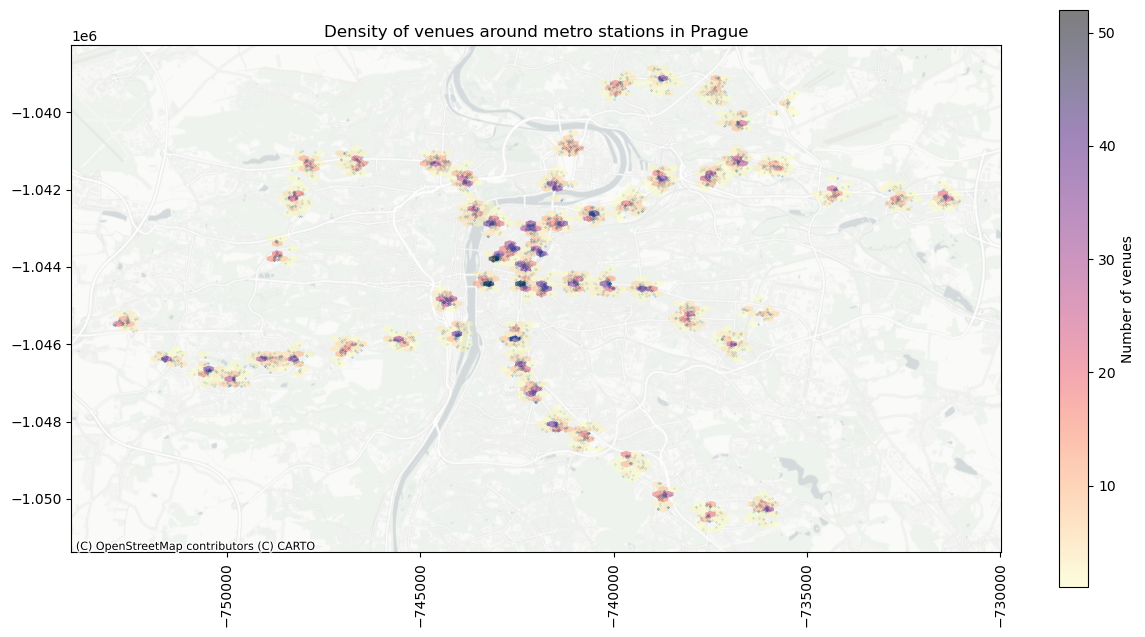

In [11]:
# Plot the density of venues
f, ax = plt.subplots(figsize=(15, 15))

venues.plot(ax=ax, markersize=0.05)
hb = ax.hexbin(
    venues.geometry.x,
    venues.geometry.y,
    gridsize=80,
    linewidths=0,
    alpha=0.5,
    cmap="magma_r",
    mincnt=1,
)
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=venues.crs,
    source="CartoDB Positron No Labels",
)
plt.colorbar(hb, shrink=0.5, label='Number of venues')
plt.xticks(rotation=90);
plt.title('Density of venues around metro stations in Prague')


The plot shows that the highest density of venues is in the city centre, with a few outliers in the outskirts of the city.


Now we will use Ripley's G function to assess the randomness of the venue pattern. Ripley's G aims to capture the co-location of points pattern, it measures how many points have the nearest point within a threshold distance while repeatedly increasing such a threshold. It is necessary to define the area of the existing point pattern, which in this case is the 400-meter buffer for each station.

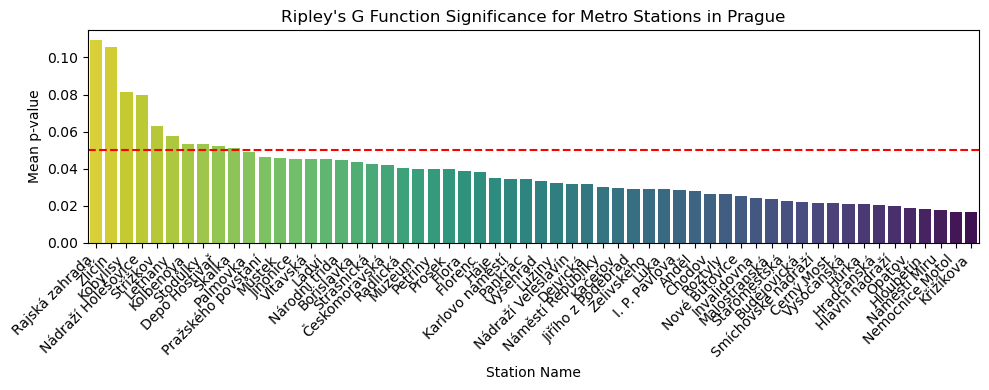

In [12]:
# Create buffer around metro stations
metrob = metro.buffer(400)

# Create a GeoDataFrame from the buffer
convex_hull = gpd.GeoDataFrame(geometry=metrob)

# Create function to calculate Ripley's G
def ripley_g(grou):
    
    convex_hull = grou.unary_union.convex_hull
    g_test = pointpats.distance_statistics.g_test(
        grou[["Venue Longitude", "Venue Latitude",]].values,
        support=50,
        keep_simulations=True,
        hull=convex_hull,
        n_simulations=99,
    )
    return np.mean(g_test.pvalue)

# Calculate Ripley's G for each metro station
ripley_significance = venues.groupby("Station Name").apply(ripley_g)

# Sort the values
ripley_significance_sorted = ripley_significance.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 4))
ax = sns.barplot(x=ripley_significance_sorted.index, y=ripley_significance_sorted.values, palette="viridis_r")
# Add line at the 0.05 significance level
ax.axhline(y=0.05, color='r', linestyle='--', label='Threshold (0.05)')
plt.xlabel("Station Name")
plt.ylabel("Mean p-value")
plt.title("Ripley's G Function Significance for Metro Stations in Prague")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The function returns the mean p-value of the G function for each metro station. The p-value measures the significance of the spatial clustering of venues around each metro station. 
The lower the p-value, the more significant the clustering. The threshold for significance is set at 0.05, which is indicated by the red dashed line in the plot.
If the mean p-value is below this threshold, we can conclude that the venues are significantly spatialy clustered around the metro station. 
The results show that the spatial clustering is significant for most metro stations, with only a few exceptions such as the stations 'Zličín', 'Rajská Zahrada' or 'Kobylisy', which are the stations located on the outskirts of the city.

And finally, let's explore the subtypes of the venues.

In [13]:
# Find out how many unique venue subtypes there are and what the most common ones are
print('Unique venue subtypes:', len(venues['Venue Subtype'].unique()), '\n')

print('Top 10 most common', venues['Venue Subtype'].value_counts().head(10), '\n')

# Find out the most common venue subtypes for each venue type
top_3_subtypes_by_type = venues.groupby('Venue Type')['Venue Subtype'].apply(lambda x: x.value_counts().nlargest(3).index.tolist())

for venue_type, top_3_subtypes in top_3_subtypes_by_type.items():
    print(f"{venue_type}: {top_3_subtypes}")


Unique venue subtypes: 464 

Top 10 most common Venue Subtype
Gym and Studio               142
Doctor's Office              121
Office Building              113
Health and Beauty Service    100
Playground                    86
Hotel                         82
Grocery Store                 81
Bus Stop                      81
Dentist                       80
Bank                          78
Name: count, dtype: int64 

Arts and Entertainment: ['Art Gallery', 'Event Space', 'Public Art']
Business and Professional Services: ['Office Building', 'Health and Beauty Service', 'Bank']
Cafes and Bakeries: ['Bakery', 'Café', 'Coffee Shop']
Community and Government: ['Residential Building', 'College Classroom', 'Government Building']
Dining and Drinking: ['Pizzeria', 'Restaurant', 'Bistro']
Health and Medicine: ["Doctor's Office", 'Dentist', 'Medical Center']
Landmarks and Outdoors: ['Playground', 'Park', 'Other Great Outdoors']
Nightlife: ['Bar', 'Night Club', 'Casino']
Retail: ['Grocery Store', '

## __Data Preparation for Clustering__

Until now we have been working with two geodataframes (metro stations and venues). In order to prepare the data for clustering, we need to extract relevant information from these geodataframes and create a new geodataframe for clustering.

The new geodataframe will have the information about the name of the metro station and the number of venues for each Venue Type. 

In [14]:
# Group venues by type
grouped_venues = venues.groupby(['Venue Type', 'Station Name']).size().reset_index(name='count')

# Pivot the counts to create new columns for each venue type
pivot_counts = grouped_venues.pivot(index='Station Name', columns='Venue Type', values='count')

# Fill any missing values with 0 and convert to integer
pivot_counts = pivot_counts.fillna(0)[['Arts and Entertainment', 'Business and Professional Services', 'Cafes and Bakeries', 'Community and Government', 'Dining and Drinking', 'Health and Medicine', 
              'Landmarks and Outdoors', 'Nightlife', 'Retail', 'Sports and Recreation', 'Travel and Transportation'
              ]].astype(int)

# Reset the index
pivot_counts = pivot_counts.reset_index().rename(columns={'index': 'Station Name'})

# Create a new column with the total number of venues
sums = pivot_counts.groupby('Station Name').sum()
sums['total'] = sums.sum(axis=1)

# Sort dataframe by the total number of venues
sorted_df = sums.sort_values('total', ascending=False)
sorted_df.head(10)


Venue Type         Arts and Entertainment  Business and Professional Services  \
Station Name                                                                    
Anděl                                   9                                  17   
Náměstí Republiky                       7                                  18   
Národní třída                           8                                  17   
I. P. Pavlova                           5                                  19   
Muzeum                                  8                                  11   
Křižíkova                              10                                  19   
Karlovo náměstí                        15                                  11   
Jiřího z Poděbrad                       8                                  13   
Náměstí Míru                            8                                  15   
Můstek                                 12                                  14   

Venue Type         Cafes and Bakeries  Community and Government  \
Station Name                                                      
Anděl                               3                         9   
Náměstí Republiky                   5                        11   
Národní třída                       4                        10   
I. P. Pavlova                       4                        11   
Muzeum                              5                        10   
Křižíkova                           3                        12   
Karlovo náměstí                     1                        12   
Jiřího z Poděbrad                   2                         9   
Náměstí Míru                        1                        10   
Můstek                              4                        10   

Venue Type         Dining and Drinking  Health and Medicine  \
Station Name                                                  
Anděl                               10                   11   
Náměstí Republiky                   10                   10   
Národní třída                       11                   12   
I. P. Pavlova                       10                   11   
Muzeum                               9                   10   
Křižíkova                           10                   10   
Karlovo náměstí                     10                   11   
Jiřího z Poděbrad                   10                   11   
Náměstí Míru                         8                   11   
Můstek                               9                   12   

Venue Type         Landmarks and Outdoors  Nightlife  Retail  \
Station Name                                                   
Anděl                                   2          9      10   
Náměstí Republiky                       4          4      11   
Národní třída                           2          7       9   
I. P. Pavlova                           2         10       9   
Muzeum                                  7         10      12   
Křižíkova                               1          4      11   
Karlovo náměstí                         6          2      13   
Jiřího z Poděbrad                      10          7      10   
Náměstí Míru                            5         11      12   
Můstek                                  5          6       9   

Venue Type         Sports and Recreation  Travel and Transportation  total  
Station Name                                                                
Anděl                                  9                         11    100  
Náměstí Republiky                      9                         11    100  
Národní třída                         10                         10    100  
I. P. Pavlova                          9                          9     99  
Muzeum                                 6                         11     99  
Křižíkova                             10                          9     99  
Karlovo náměstí                        9                          9     99  
Jiř

In [15]:
sorted_df.tail()

Venue Type     Arts and Entertainment  Business and Professional Services  \
Station Name                                                                
Stodůlky                            0                                  11   
Zličín                              2                                   8   
Roztyly                             2                                  14   
Depo Hostivař                       2                                  13   
Letňany                             0                                   0   

Venue Type     Cafes and Bakeries  Community and Government  \
Station Name                                                  
Stodůlky                        1                         6   
Zličín                          2                         2   
Roztyly                         3                         1   
Depo Hostivař                   1                         2   
Letňany                         4                         1   

Venue Type     Dining and Drinking  Health and Medicine  \
Station Name                                              
Stodůlky                         9                    2   
Zličín                           7                    2   
Roztyly                          7                    1   
Depo Hostivař                    2                    1   
Letňany                          1                    0   

Venue Type     Landmarks and Outdoors  Nightlife  Retail  \
Station Name                                               
Stodůlky                            9          3      10   
Zličín                              3          3      13   
Roztyly                             9          2       6   
Depo Hostivař                       2          1       5   
Letňany                             0          0       4   

Venue Type     Sports and Recreation  Travel and Transportation  total  
Station Name                                                            
Stodůlky                           2                          2     55  
Zličín                             4                          9     55  
Roztyly                            0                         10     55  
Depo Hostivař                      1                          4     34  
Letňany                            1                          5     16

We also added the information about the number of total venues for each station. As expected, the stations with the highest number of venues are the stations in the city center, while the stations with the lowest number of venues are the stations on the outskirts of the city.

In order to visualize the clusters, we need to add the coordinates of the metro stations to the new geodataframe.

We will also scale the data to a fixed range to ensure that the clustering algorithm is not biased towards features with a larger range of values.

In [16]:
# Add the information about the number of venues to the metro stations GeoDataFrame
stations_venues = pd.merge(metro, pivot_counts, how='left', on='Station Name')

# Change the scale of the data
data = stations_venues[['Arts and Entertainment', 'Business and Professional Services', 'Cafes and Bakeries', 'Community and Government', 'Dining and Drinking',
                      'Health and Medicine', 'Landmarks and Outdoors', 'Nightlife', 'Retail', 'Sports and Recreation', 'Travel and Transportation']].values
# Cluster_dataset = data
cluster_dataset = MinMaxScaler().fit_transform(data)

# Add the scaled data to a dataframe
category_list = ['Arts and Entertainment', 'Business and Professional Services', 'Cafes and Bakeries', 'Community and Government', 'Dining and Drinking',
                      'Health and Medicine', 'Landmarks and Outdoors', 'Nightlife', 'Retail', 'Sports and Recreation', 'Travel and Transportation']
cluster_df = pd.DataFrame(cluster_dataset)
cluster_df.columns = [c for c in category_list]
cluster_df.head(2)

Arts and Entertainment  Business and Professional Services  \
0                     0.6                            0.894737   
1                     0.2                            0.684211   

   Cafes and Bakeries  Community and Government  Dining and Drinking  \
0               0.375                  0.666667             0.769231   
1               0.500                  0.666667             0.307692   

   Health and Medicine  Landmarks and Outdoors  Nightlife    Retail  \
0             0.916667                0.181818   0.818182  0.500000   
1             0.833333                0.363636   0.090909  0.666667   

   Sports and Recreation  Travel and Transportation  
0               0.818182                   0.833333  
1               0.545455                   0.500000

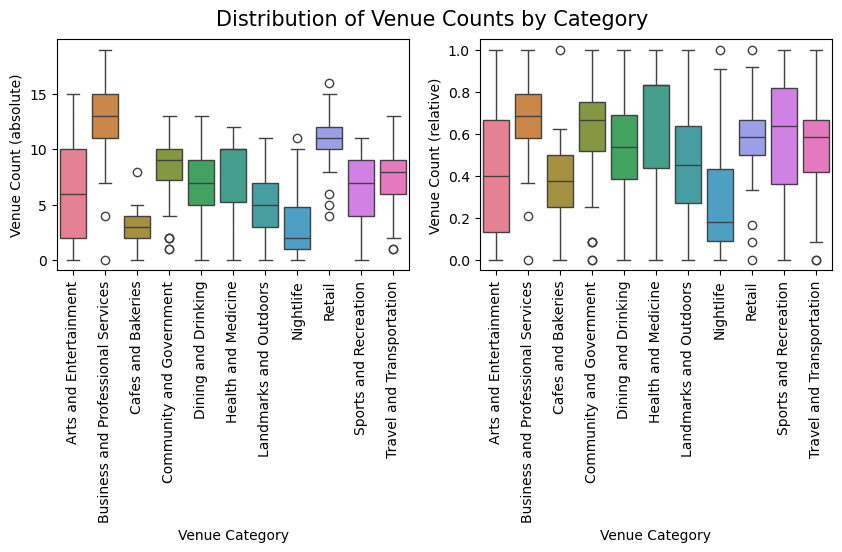

In [17]:
# Plot the distribution of the venue counts
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot the absolute values 
sns.boxplot(data=sorted_df[['Arts and Entertainment', 'Business and Professional Services', 'Cafes and Bakeries', 'Community and Government', 'Dining and Drinking', 'Health and Medicine', 
                             'Landmarks and Outdoors', 'Nightlife', 'Retail', 'Sports and Recreation', 'Travel and Transportation']], ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation='vertical')  
axes[0].set_ylabel('Venue Count (absolute)', fontsize=10)
axes[0].set_xlabel('Venue Category', fontsize=10)

# Plot the normalized values
sns.boxplot(data=cluster_df, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation='vertical')  
axes[1].set_ylabel('Venue Count (relative)', fontsize=10)
axes[1].set_xlabel('Venue Category', fontsize=10)

plt.suptitle('Distribution of Venue Counts by Category', fontsize=15)
plt.show()

The plot above shows that the absolute distribution of the venue counts is skewed.
This is expected as there are stations with a high number of venues but also stations with a lower number of venues.
The relative distribution of the venue counts is more uniform, which is what we want for clustering.

### __Clustering__

Clustering categorizes the data based on the degree of similarity within the same class.
In this essay we will use the K-means clustering algorithm to cluster the metro stations based on the number of venues in each category and
Agglomerative Clustering algorithm to cluster the metro stations based on their spatial connectivity as well as by the number of venues in each category.


When choosing the optimal number od clusters, the Elbow method and Sillhouette score did not give a clear indication of the optimal number of clusters, so we will decide not to use them and to go with 6 clusters as it seems to give satisfactory results.

In [18]:
# Run k-means clustering
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(cluster_dataset)

# Create a new dataframe that includes information about cluster 
stations_clusters_df = stations_venues.copy()
stations_clusters_df['Cluster'] = kmeans.labels_

# Create a new dataframe with the cluster labels
stations_clusters_minmax_df = cluster_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans.labels_
stations_clusters_minmax_df['Station Name'] = stations_venues['Station Name']
stations_clusters_minmax_df['Coordinates'] = stations_venues['Coordinates']

In [19]:
# Create a function to create point geometry to plot the results
def create_point_geometry(coord_str):
    latitude, longitude = map(float, coord_str.split(','))
    return Point(longitude, latitude)

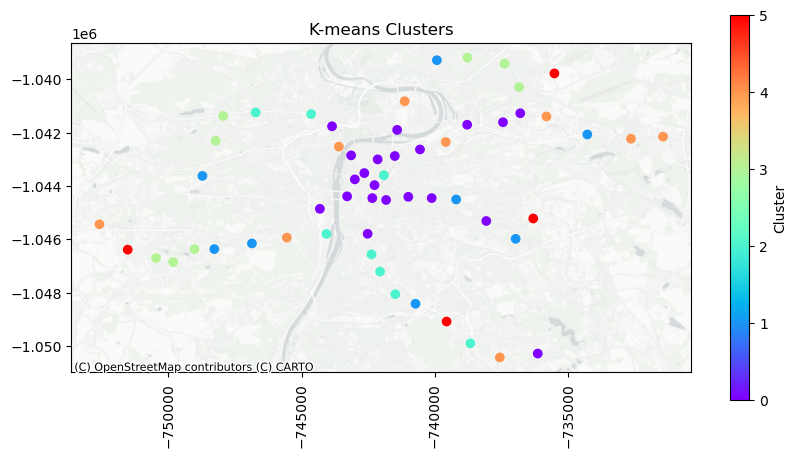

Number of stations in clusters:
 Cluster
0    21
4     9
2     8
1     8
3     8
5     4
Name: count, dtype: int64


In [20]:
# Create point geometry for K-Means clusters
stations_clusters_minmax_df['geometry'] = stations_clusters_minmax_df['Coordinates'].apply(create_point_geometry)

#Create GeoDataFrame
kmeans_clusters = gpd.GeoDataFrame(stations_clusters_minmax_df, geometry='geometry', crs='EPSG:5514')

# Plot the clusters
ax =kmeans_clusters.plot(column='Cluster', legend=True, figsize=(10, 10), cmap='rainbow',legend_kwds={'shrink': 0.5, 'label': 'Cluster'})
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=kmeans_clusters.crs,
    source="CartoDB Positron No Labels",
)
plt.title('K-means Clusters')
plt.xticks(rotation=90);
plt.show()

# Print the number of stations in each cluster of the K-Means clusters
print('Number of stations in clusters:\n', kmeans_clusters['Cluster'].value_counts())

It may be assumed that the catchment areas of stations that are close to each other should not be significantly different, but the plot shows that the clusters are scattered across the city and that stations close to one another do not often tend to cluster together. Therefore we will try to create clusters which reflect the spatial connectivity of the metro stations with agglomerative clustering that creates clusters not only according to the venue pattern but also according to the spatial connectivity of the metro stations. Hence, we add information about neighboring metro stations to each station.

In [21]:
# Create graph connectivity
neighbors = {
    'Anděl': ['Smíchovské nádraží', 'Karlovo náměstí'],
    'Bořislavka': ['Nádraží Veleslavín', 'Dejvická'],
    'Budějovická': ['Pankrác', 'Kačerov'],
    'Chodov': ['Roztyly', 'Opatov'],
    'Dejvická': ['Bořislavka', 'Hradčanská'],
    'Depo Hostivař': ['Skalka'],
    'Flora': ['Jiřího z Poděbrad', 'Želivského'],
    'Florenc': ['Hlavní nádraží', 'Náměstí Republiky', 'Křižíkova', 'Vltavská'],
    'Hlavní nádraží': ['Florenc', 'Muzeum'],
    'Hloubětín': ['Kolbenova', 'Rajská zahrada'],
    'Hradčanská': ['Dejvická', 'Malostranská'],
    'Háje': ['Opatov'],
    'Hůrka': ['Lužiny', 'Nové Butovice'],
    'I. P. Pavlova': ['Muzeum', 'Vyšehrad'],
    'Invalidovna': ['Palmovka', 'Křižíkova'],
    'Jinonice': ['Nové Butovice', 'Radlická'],
    'Jiřího z Poděbrad': ['Flora', 'Náměstí Míru'],
    'Karlovo náměstí': ['Anděl', 'Národní třída'],
    'Kačerov': ['Budějovická', 'Roztyly'],
    'Kobylisy': ['Ládví', 'Nádraží Holešovice'],
    'Kolbenova': ['Hloubětín', 'Vysočanská'],
    'Křižíkova': ['Florenc', 'Invalidovna'],
    'Letňany': ['Prosek'],
    'Luka': ['Lužiny', 'Stodůlky'],
    'Lužiny': ['Hůrka', 'Luka'],
    'Ládví': ['Kobylisy', 'Střížkov'],
    'Malostranská': ['Hradčanská', 'Staroměstská'],
    'Muzeum': ['Hlavní nádraží', 'Můstek', 'I. P. Pavlova', 'Náměstí Míru'],
    'Můstek': ['Muzeum', 'Náměstí Republiky', 'Staroměstská', 'Národní třída'],
    'Nemocnice Motol': ['Petřiny'],
    'Nové Butovice': ['Hůrka', 'Jinonice'],
    'Nádraží Holešovice': ['Kobylisy', 'Vltavská'],
    'Nádraží Veleslavín': ['Bořislavka', 'Petřiny'],
    'Náměstí Míru': ['Jiřího z Poděbrad', 'Muzeum'],
    'Náměstí Republiky': ['Florenc', 'Můstek'],
    'Národní třída': ['Karlovo náměstí', 'Můstek'],
    'Opatov': ['Chodov', 'Háje'],
    'Palmovka': ['Českomoravská', 'Invalidovna'],
    'Pankrác': ['Budějovická', 'Pražského povstání'],
    'Petřiny': ['Nádraží Veleslavín', 'Nemocnice Motol'],
    'Pražského povstání': ['Vyšehrad', 'Pankrác'],
    'Prosek': ['Letňany', 'Střížkov'],
    'Radlická': ['Jinonice', 'Smíchovské nádraží'],
    'Rajská zahrada': ['Černý Most', 'Hloubětín'],
    'Roztyly': ['Chodov', 'Kačerov'],
    'Skalka': ['Depo Hostivař', 'Strašnická'],
    'Smíchovské nádraží': ['Anděl', 'Radlická'],
    'Staroměstská': ['Malostranská', 'Můstek'],
    'Stodůlky': ['Luka', 'Zličín'],
    'Strašnická': ['Skalka', 'Želivského'],
    'Střížkov': ['Ládví', 'Prosek'],
    'Vltavská': ['Florenc', 'Nádraží Holešovice'],
    'Vysočanská': ['Kolbenova', 'Českomoravská'],
    'Vyšehrad': ['Pražského povstání', 'I. P. Pavlova'],
    'Zličín': ['Stodůlky'],
    'Černý Most': ['Rajská zahrada'],
    'Českomoravská': ['Vysočanská', 'Palmovka'],
    'Želivského': ['Flora', 'Strašnická'],
}

# Build the graph
connectivity = graph.Graph.from_dicts(neighbors, weights=None)

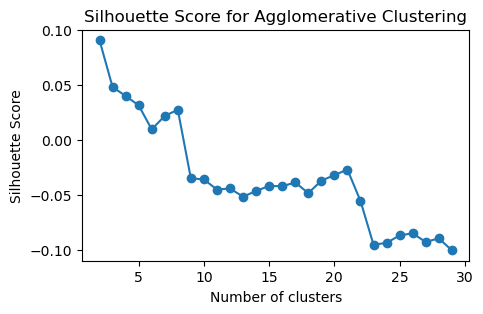

In [22]:
# Use the silhouette score to find the optimal number of clusters
range_clusters = range(2, 30)
scores = []
for k in range_clusters:
    agg = AgglomerativeClustering(n_clusters=k, connectivity=connectivity.sparse).fit(cluster_dataset)
    score = silhouette_score(cluster_dataset, agg.labels_, metric='euclidean')
    scores.append(score)

plt.figure(figsize=(5, 3))
plt.plot(range_clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.show()

The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
Silhoutte Score gives high values for 2 and then for 8 cluster which is not enough when considering the spatial connectivity of the metro stations. The clusters would be too big 
and tend to form big clusters along each metro line and that is not what we want.
The score for 21 clusters is not the highest, but it will give better results when considering the spatial connectivity of the metro stations. 
Therefore, we will use 21 clusters for the Agglomerative Clustering and then use K-means to cluster most similar clusters into only 6 clusters.


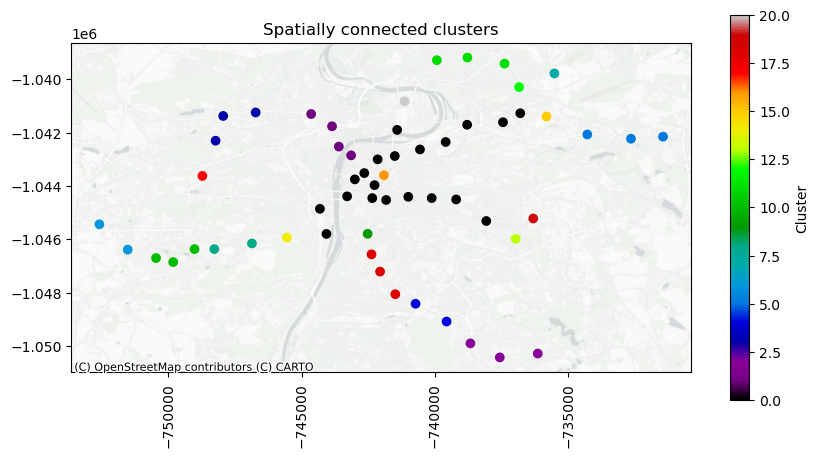

 Number of stations in clusters:
 Cluster
0     20
1      4
3      3
18     3
2      3
11     3
5      3
10     3
6      2
4      2
8      2
16     1
15     1
7      1
17     1
20     1
12     1
14     1
13     1
19     1
9      1
Name: count, dtype: int64


In [23]:
# Perfrom agglomerative clustering
agg21 = AgglomerativeClustering(n_clusters=21, connectivity=connectivity.sparse).fit(cluster_dataset)

# Create a new dataframe with the cluster centers
clusters21 = kmeans_clusters.copy()
clusters21['Cluster'] = agg21.labels_

# Plot the clusters
ax =clusters21.plot(column='Cluster', legend=True, figsize=(10, 10), cmap='nipy_spectral',legend_kwds={'shrink': 0.5, 'label': 'Cluster'})
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=clusters21.crs,
    source="CartoDB Positron No Labels",
)

plt.title('Spatially connected clusters')
plt.xticks(rotation=90);
plt.show()

# Print the number of stations in each cluster of the Agglomerative clusters
print(' Number of stations in clusters:\n', clusters21['Cluster'].value_counts())

Clusters created by this algorithm contain a very little number of stations and are too small to derive any meaningful information.
Therefore we will use the K-means clustering algorithm on these clusters to merge the most similar clusters into new, more meaningful clusters.
We will use 6 clusters, so we compare the result with the original K-means clustering.

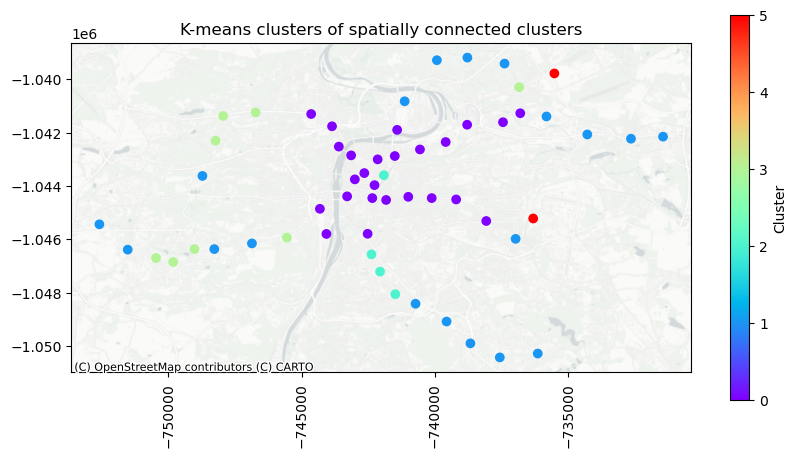

Spatially constrained K-means clusters:
 Cluster
0    25
1    19
3     8
2     4
5     2
Name: count, dtype: int64


In [34]:
# Group the venues by clusters
sd = clusters21[['Arts and Entertainment', 'Business and Professional Services', 'Cafes and Bakeries', 'Community and Government', 'Dining and Drinking',
                                  'Health and Medicine', 'Landmarks and Outdoors', 'Nightlife', 'Retail', 'Sports and Recreation', 'Travel and Transportation', 'Cluster']].copy()
group = sd.groupby('Cluster').mean()

# Perform kmeans clustering to merge the clusters
agg_kmeans = KMeans(n_clusters=5, random_state=42).fit(group)

# Add the new labels to the group dataframe
group["new_label"] = agg_kmeans.labels_
clusters_merged = clusters21.copy()

# Assign the new labels to the Cluster column
clusters_merged['Cluster'] = clusters_merged['Cluster'].map(group["new_label"].to_dict())

# Change the cluster numbers to match the colors of the original k-means clusters
label_replacements = {3: 2, 
                2: 1,
                1: 3,
                0: 5, 
                4: 0} 
clusters_merged['Cluster'] = clusters_merged['Cluster'].replace(label_replacements)

# Plot the clusters
ax =clusters_merged.plot(column='Cluster', legend=True, figsize=(10, 10), cmap='rainbow',legend_kwds={'shrink': 0.5, 'label': 'Cluster'})
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=clusters_merged.crs,
    source="CartoDB Positron No Labels",
)

plt.title('K-means clusters of spatially connected clusters')
plt.xticks(rotation=90);
plt.show()

# Print the number of stations in each cluster of the merged clusters
print('Spatially constrained K-means clusters:\n', clusters_merged['Cluster'].value_counts())

Now lets compare the spatial distribution of the clusters as well as their structure.

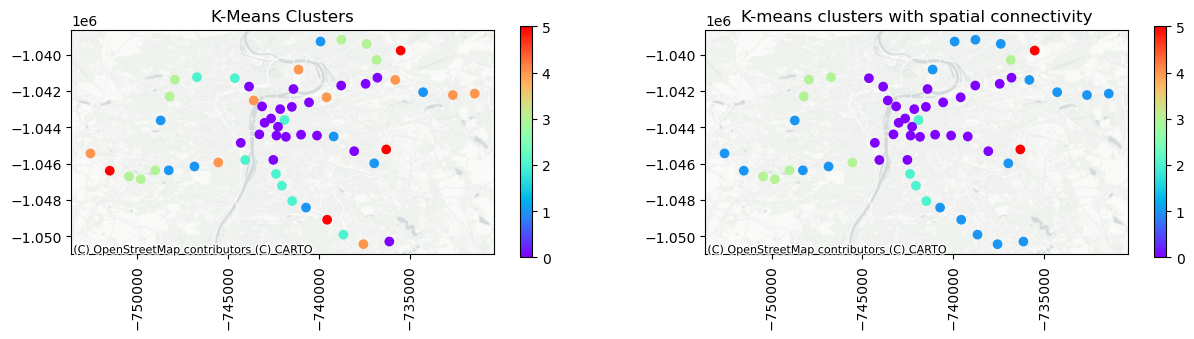

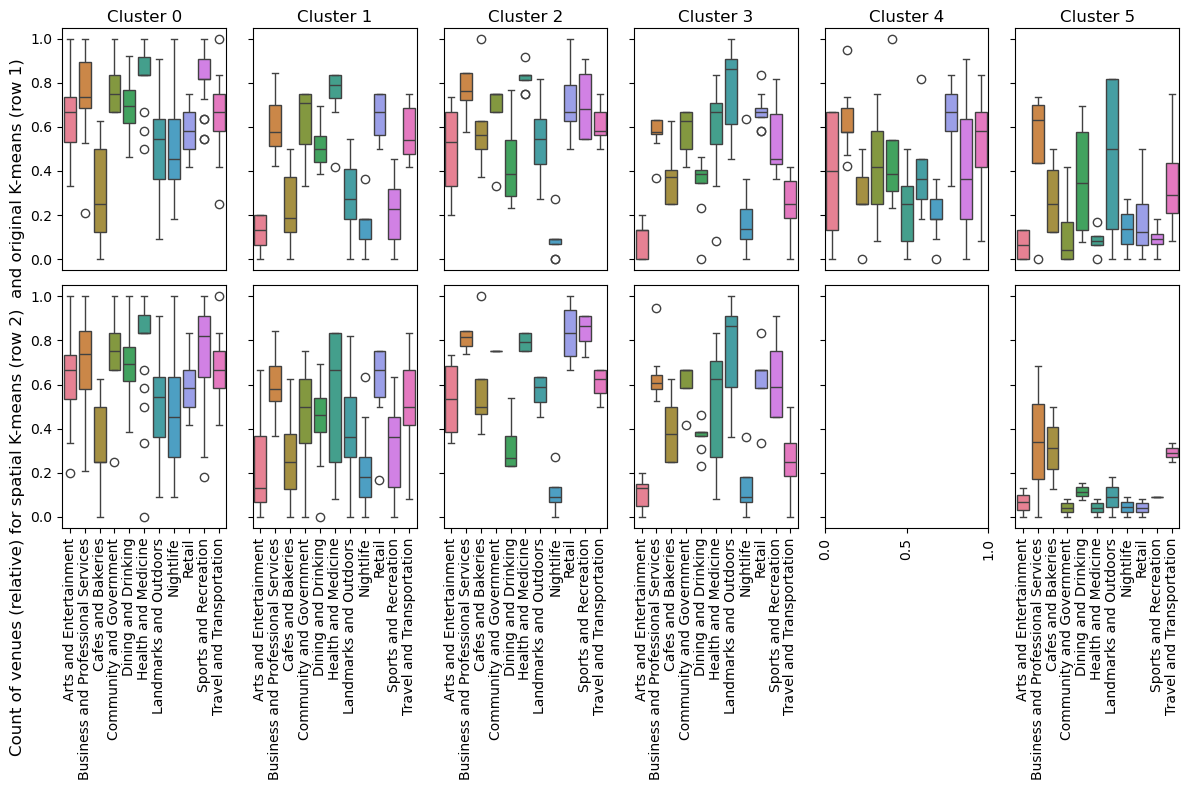

In [37]:
# Plot the clusters from original K-Means 
plt.figure(figsize=(15, 15))  

plt.subplot(1, 2, 1)  
kmeans_clusters.plot(column='Cluster', cmap='rainbow', legend=True, legend_kwds={'shrink': 0.2},ax=plt.gca())
plt.title('K-Means Clusters')
contextily.add_basemap(
    ax=plt.gca(), 
    crs=kmeans_clusters.crs,
    source="CartoDB Positron No Labels")
plt.xticks(rotation=90);

# Plot the clusters from spatial K-means clustering
plt.subplot(1, 2, 2)  
clusters_merged.plot(column='Cluster', cmap='rainbow', legend=True, legend_kwds={'shrink': 0.2}, ax=plt.gca())
plt.title('K-means clusters with spatial connectivity')
contextily.add_basemap(
    ax=plt.gca(), 
    crs=clusters_merged.crs, 
    source="CartoDB Positron No Labels")
plt.xticks(rotation=90);

plt.show()

# Plot the structure of the clusters of both original K-Means and spatial K-means clustering
fig, axes = plt.subplots(2, 6, figsize=(12, 8), sharey='row')

for k in range(kclusters):

    axes[0, k].xaxis.set_label_position('top')
    axes[0, k].set_xlabel('Cluster ' + str(k), fontsize=12)
    axes[0, k].tick_params(labelsize=10)
    plt.sca(axes[0, k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data=stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop(columns='Cluster'), ax=axes[0, k])
    axes[0, k].set_xticks([])  

# Plot the second set of subplots
axes[1, 0].set_ylabel('Count of venues (relative) for spatial K-means (row 2)  and original K-means (row 1)', fontsize=12)

for k in range(kclusters):
    axes[1, k].tick_params(labelsize=10)
    plt.sca(axes[1, k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data=clusters_merged[clusters_merged['Cluster'] == k].drop(columns='Cluster'), ax=axes[1, k])

plt.tight_layout()
plt.show()


## __Results__

The clusters produced by both algorithms are quite similar. However, the clusters generated by agglomerative clustering and K-means algorithm based on the spatial connectivity  (hereafter referred to as spatial K-means) have more variance in their structure in terms of the number of locations in each category than the clusters generated by the original K-means algorithm. Nevertheless, the clusters from the spatial K-means seem to produce more meaningful clusters, based on which a typology of metro station catchment areas can be designed.

 -  Cluster 0 (purple) represents the metro stations that are mostly located in the city centre and have the highest overall number of venues, especially in the
category of Nightlife, compared to the other clusters.

 - Cluster 2 (cyan) is similar to Cluster 0. It contains fewer metro stations and has a lower number of venues in all categories.
It has much lower values in the Nightlife category than Cluster 0, but has high values in the Bussiness and Professional Services, Retail and also Cafes and Bakeries categories,indicating that these stations are not located near to tourist locations in the city center, but rather are surrounded by offices and commercial places in the wider city area.

- Both of these clusters are well connected in terms of transport connections, suggesting that stations in this cluster are the most used by the residents of Prague

 - Stations in Cluster 3 (green) have very low values in the category of Arts and Entertainment, but very high values in the category of Landmarks and Outdoors. The counts in the Landmarks and Outdoors category are the highest across all clusters and most stations in this cluster are located west of the Vltava River.

 - The median values of Cluster 1 (blue) for the number of venues tend to be very similar for all categories. The cluster consists of stations 
that are located at the ends of metro lines

 - The structure of Cluster 5 (red) is similar to Cluster 1, but Cluster 5 has overall lower values in all categories, especially in the Arts and Entertainment, Sports and Recreation and Landmarks and Outdoors categories. The Metro stations in this cluster are located at either ends of metro line B and are not as well-equiped as those in Cluster 1 because they have fewer leisure options.

 - The proposed typology is as follows:
      - Cluster 0 (purple): Most developed stations, used for all kind of purposes.
      - Cluster 1 (blue): Well-equipped stations in the residential areas on the outskirts of the city.
      - Cluster 2 (cyan): Stations near Commercial and Business areas.
      - Cluster 3 (green): Well-equipped stations on the outskirts of the city, surrounded by parks and other outdoor places. 
      - Cluster 5 (red): Least developed stations with the lowest number of venues.
 

## __Conclusion__

In order to gain better understanding of the structure of the clusters, it would be beneficial to explore the clusters in more detail. 
This could be done by examining the most common venue subtypes in each cluster.
Also, some of the clusters are quite similar and it would be worth creating more categories to obtain more distinct clusters. 
For example, the category of 'Business and Professional Services' could be split into two separate categories, for example
'Personal and Beauty Services' and 'Commercial and Financial Services'. Another option would be to use a different number of clusters.

For a more accurate analysis it would be useful to search for venues not by a fixed radius around the metro stations,
but rather by a street network and the actual walking distance from the stations. 
It would also be better to not to use the centroids of metro stations entrances, but the actual metro station entrances which would also overcome the limitation of maximum 100 venues per metro station.